In [7]:
from scipy.stats import zscore
from scipy.ndimage import gaussian_filter1d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import zscore
%matplotlib inline

# download 2-photon data (if not already downloaded)
if not os.path.isfile('data/mesoscope_activity.npy'):
    if not os.path.exists('data'):
        os.mkdir('data')
    response = urllib.request.urlopen('http://www.gatsby.ucl.ac.uk/~cstringer/mesoscope_activity.npy');
    f=open('data/mesoscope_activity.npy','wb')
    f.write(response.read())
    f.close()

 

   
# load downloaded data
dat = np.load('data/mesoscope_activity.npy')
dat = dat.item()
sp  = dat['spks']
sp  = zscore(sp, axis=1)
xyloc = dat['xyloc']

In [19]:
# rastermap algorithm
import sys
sys.path.append('/media/carsen/DATA2/Github/rastermap/rastermap/')
from mapping import Rastermap

# rastermap works the same as TSNE or UMAP
# (will take ~10s for 6000 neurons x 20000 timepts on a laptop)
# class Rastermap:
"""rastermap embedding algorithm
    Rastermap first takes the top iPC's of the data, and then embeds them into
    n_X clusters. It returns upsampled cluster identities (n_X*upsamp).
    Clusters are also computed across Y (n_Y) and smoothed, to help with fitting.
    If n_components=2, n_X x n_X components are used.
    
    Parameters
    -----------
    n_components: int, optional (default: 1)
        dimension of the embedding space
    n_X: int, optional (default: 40)
        number of clusters in X
    n_Y: int, optional (default: 0)
        number of clusters in Y: will be used to smooth data before sorting in X
        if set to zero, no smoothing will occur
    iPC: nparray, int, optional (default: 0-399)
        which PCs to use during optimization
    nPC: int, optional (default: 400)
        if used, will take 0-nPC PCs during optimization
    init : initialization of algorithm (default: 'pca')
        can use 'pca', 'random', or a matrix n_samples x n_components
        
    Attributes
    ----------
    embedding : array-like, shape (n_samples, n_components)
        Stores the embedding vectors.
    u,sv,v : singular value decomposition of data S, potentially with smoothing
    
"""

model = Rastermap(n_components=1, n_X=40, n_Y=0, nPC=400, init='pca')
model.fit(sp)

(21, 30)
time; iteration;  explained PC variance
0.01s     0        0.0310
0.05s    10        0.0973
0.10s    20        0.1268
0.15s    30        0.1540
0.20s    40        0.1583
0.25s    50        0.1587
0.26s   final      0.1587
0.26s upsampled    0.1666


In [27]:
### sort neurons and smooth across neurons and zscore in time
isort = np.argsort(model.embedding[:,0])
Sm = gaussian_filter1d(sp[isort,:].T, np.minimum(3,int(sp.shape[0]*0.005)), axis=1)
Sm = Sm.T

# (optional) smooth in time
Sm = gaussian_filter1d(Sm, 1, axis=1)


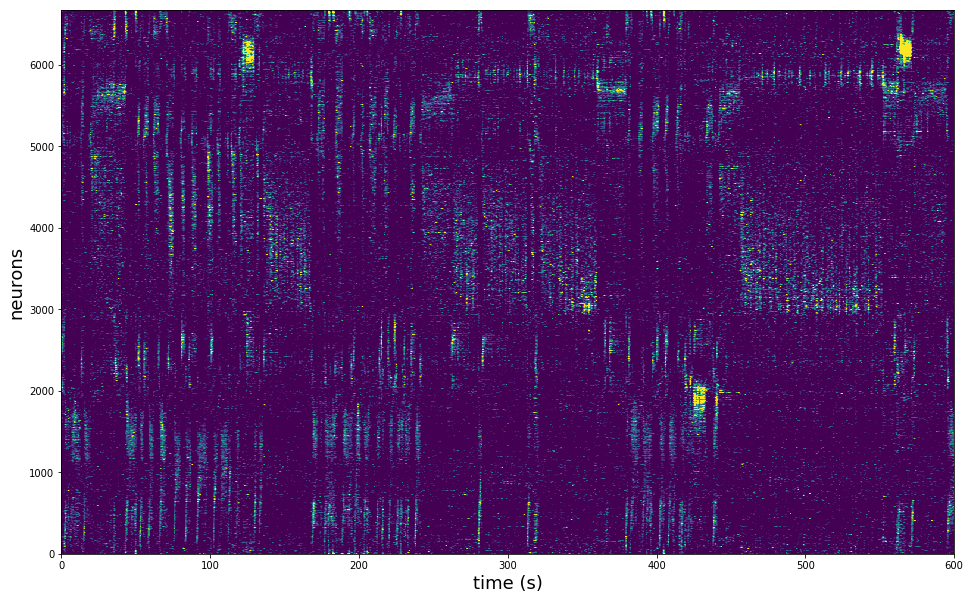

In [31]:
### view neuron sorting
fs = 2.5 # sampling rate of data in Hz
splot = Sm[::-1,1500:3000]
plt.figure(figsize=(16,10))
ax=plt.imshow(splot, vmin=0,vmax=1.5,aspect='auto',extent=[0,splot.shape[1]/fs, 0,splot.shape[0]])
plt.xlabel('time (s)', fontsize=18)
plt.ylabel('neurons', fontsize=18)
plt.show()

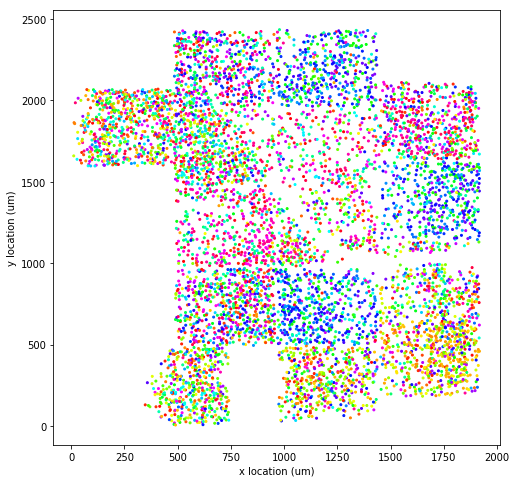

In [32]:
### view positions of cells colored by rastermap

# colormap
cmap = cm.get_cmap('hsv')
cmap = cmap(np.linspace(0.,1,sp.shape[0]))

plt.figure(figsize=(8,8))
# assign color based on embedding
plt.scatter(xyloc[:,0], xyloc[:,1], s=4, color=cmap[isort,:])
plt.xlabel('x location (um)')
plt.ylabel('y location (um)');
plt.show()